In [78]:
# Model design
import agentpy as ap
import random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython


In [93]:
# If agentpy is not installed, uncomment this
# ! pip install agentpy

In [94]:

'''
Rules of the system:
1. A burning tree becomes an empty site
2. A green tree becomes burning if at least one of its neighbours is burning
3. At an empty site, a tree grows with the probability p
4. A tree without a burning neighbour becomes a burning tree at any time step with the probability f ('lightning')

Modifications needed:
1. Do not automatically start the burning
2. Add a condition where a tree starts growing
3. Adjust probabilities
4. Do not stop the animation
Hello :)
'''

"\nRules of the system:\n1. A burning tree becomes an empty site\n2. A green tree becomes burning if at least one of its neighbours is burning\n3. At an empty site, a tree grows with the probability p\n4. A tree without a burning neighbour becomes a burning tree at any time step with the probability f ('lightning')\n\nModifications needed:\n1. Do not automatically start the burning\n2. Add a condition where a tree starts growing\n3. Adjust probabilities\n4. Do not stop the animation\nHello :)\n"

In [ ]:
class ForestModel(ap.Model):

    def setup(self):

        # Create agents (trees)
        n_trees = int(self.p['Tree density'] * (self.p.size**2))
        trees = self.agents = ap.AgentList(self, n_trees)

        # Create grid (forest)
        self.forest = ap.Grid(self, [self.p.size]*2, track_empty=True)
        self.forest.add_agents(trees, random=True, empty=True)

        # Initiate a dynamic variable for all trees
        # Condition 0: Alive, 1: Burning, 2: Empty
        self.agents.condition = 0

        # Probability of lightning
        self.f = self.p['probability of lightning']

        # Probability of tree growth
        self.new = self.p['probability of new tree']

        # Start a fire from the left side of the grid
        # unfortunate_trees = self.forest.agents[0:self.p.size, 0:2]
        # unfortunate_trees.condition = 1
        #added:
        self.tree_counts = []  # Initialize list to store number of trees

    def step(self):

        # Select burning trees
        burning_trees = self.agents.select(self.agents.condition == 1)

        # Select empty lots
        no_trees = self.agents.select(self.agents.condition == 2)

        # Select healthy trees
        healthy_trees = self.agents.select(self.agents.condition == 0)

        # Add lighting
        for tree in healthy_trees:
            if random.random() < self.f:
                tree.condition = 1

        # Spread fire
        for tree in burning_trees:
            for neighbor in self.forest.neighbors(tree):
                if neighbor.condition == 0:
                    neighbor.condition = 1 # Neighbor starts burning
            tree.condition = 2 # Tree burns out
        nr_trees = len(self.agents.select(self.agents.condition == 0))
        self.tree_counts.append(nr_trees)  # Save number of trees at each step
        
        for tree in no_trees:
            if random.random() < self.new:
                tree.condition = 0

        # Stop simulation if no fire is left
       # if len(burning_trees) == 0:
        #    self.stop()

    def end(self):

        # Document a measure at the end of the simulation
        burned_trees = len(self.agents.select(self.agents.condition == 2))
        self.report('Percentage of burned trees',
                    burned_trees / len(self.agents))

In [81]:
# Define parameters

parameters = {
    'Tree density': 0.5, # Percentage of grid covered by trees
    'size': 50, # Height and length of the grid
    'steps': 200,
    'probability of lightning': 0.001,
    'probability of new tree': 0.05
}

In [ ]:
# Create single-run animation with custom colors

def animation_plot(model, ax):
    attr_grid = model.forest.attr_grid('condition')
    color_dict = {0:'#7FC97F', 1:'#d62c2c', 2:'#e5e5e5', None:'#d5e5d5'}
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(f"Simulation of a forest fire\n"
                 f"Time-step: {model.t}, Trees left: "
                 f"{len(model.agents.select(model.agents.condition == 0))}")


# fig, ax = plt.subplots()
# model = ForestModel(parameters)
# animation = ap.animate(model, fig, ax, animation_plot)
# IPython.display.HTML(animation.to_jshtml(fps=15))


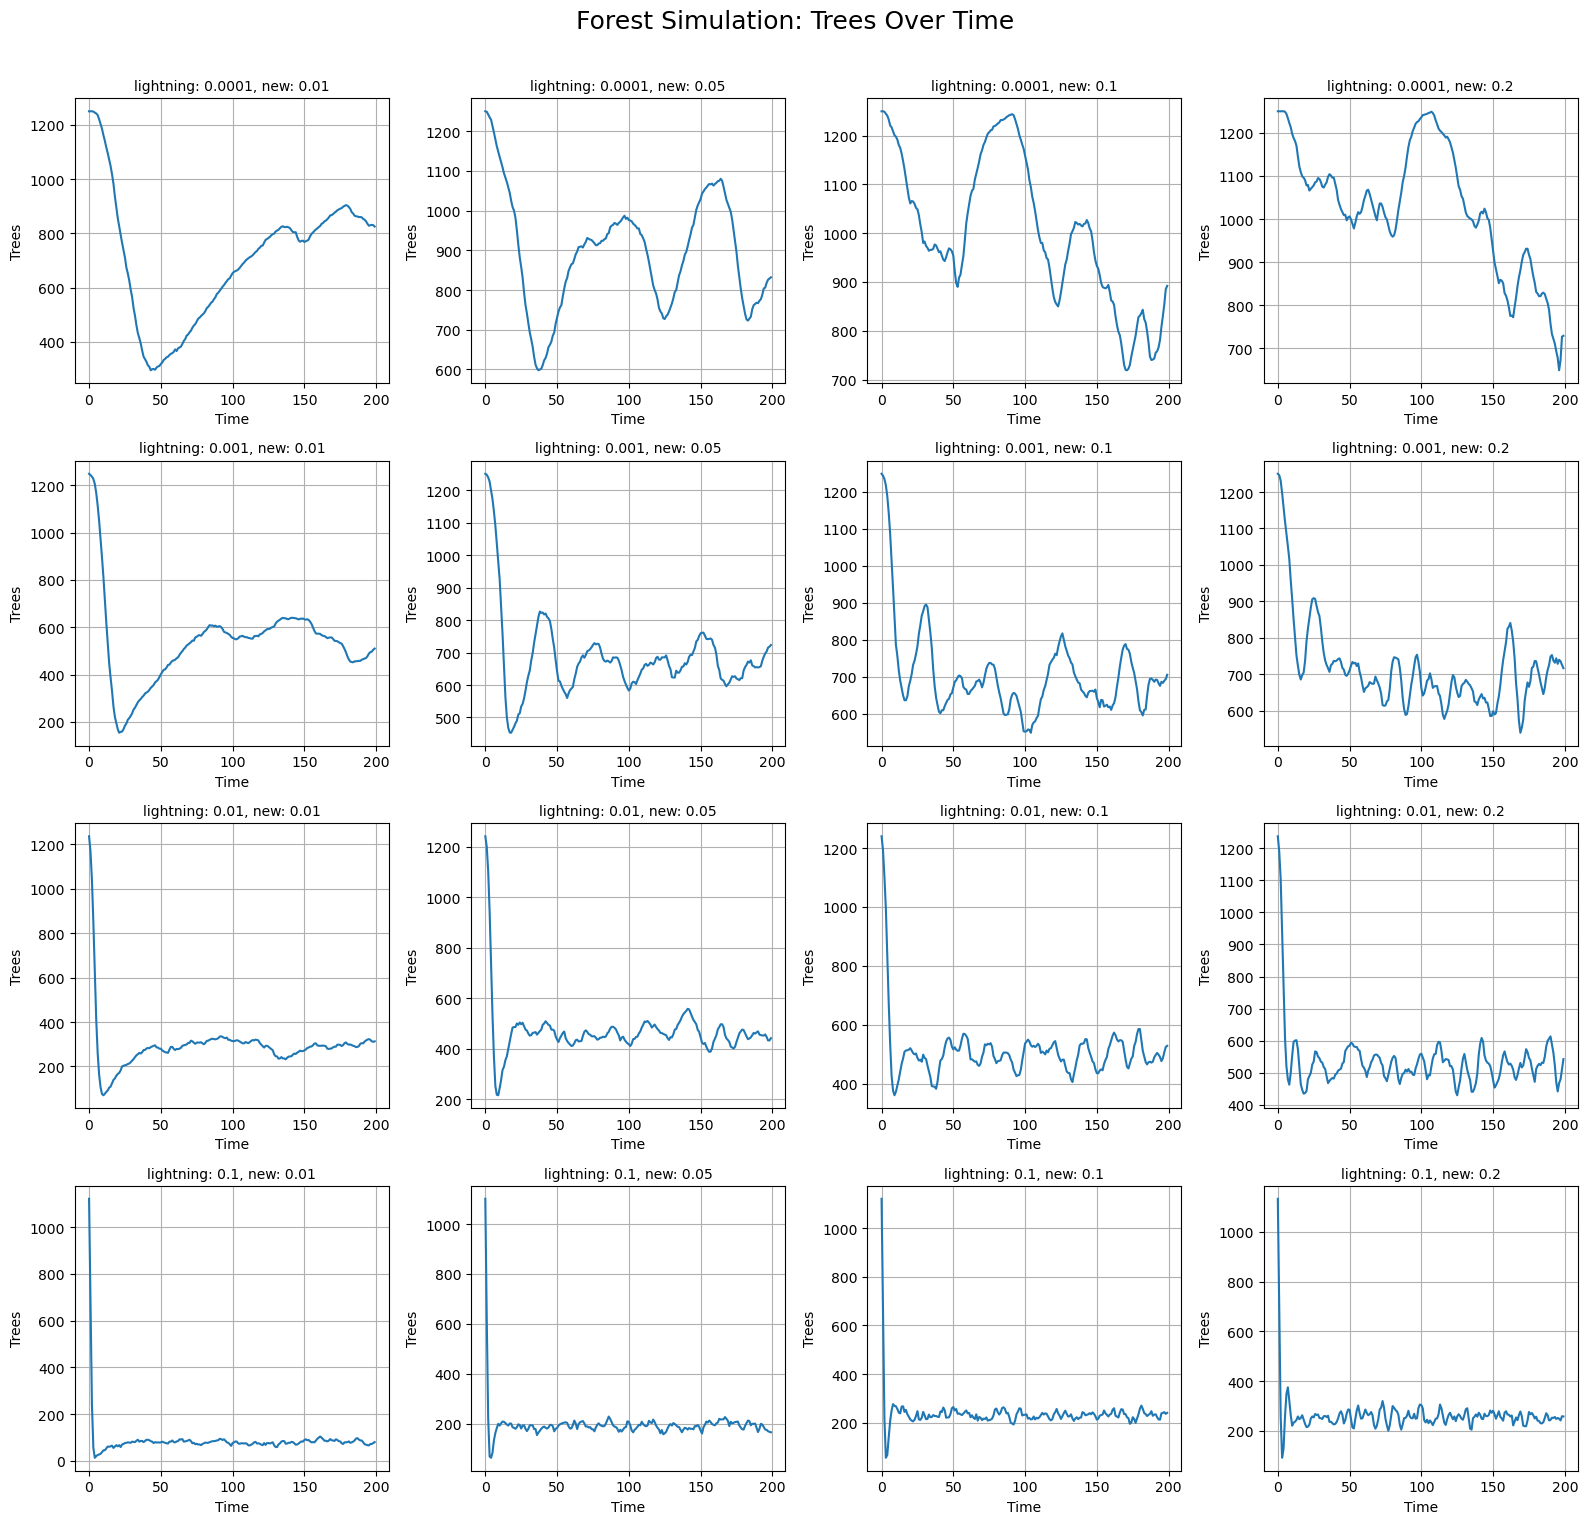

In [83]:
import matplotlib.pyplot as plt


list_lightning = [0.0001, 0.001, 0.01, 0.1]
list_new_tree = [0.01, 0.05, 0.1, 0.2]

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle("Forest Simulation: Trees Over Time", fontsize=18)
for i,f in enumerate(list_lightning):
    for j,p in enumerate(list_new_tree):
        parameters['probability of lightning'] = f
        parameters['probability of new tree'] = p
        model = ForestModel(parameters)
        model.setup()  # initialize model

        # run your simulation manually:
        for step in range(parameters['steps']):
            model.step()
        trees = model.tree_counts
        time = list(range(len(trees)))
    
        ax = axes[i][j]
        ax.plot(time, trees)
        ax.set_title(f"lightning: {f}, new: {p}", fontsize=10)
        ax.set_xlabel("Time")
        ax.set_ylabel("Trees")
        ax.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust for title
plt.show()